In [1]:
# Install required libraries
!pip install --quiet --upgrade diffusers transformers accelerate
!pip install --quiet safetensors
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 103.4 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login

login()

In [4]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from diffusers.utils import load_image

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
from PIL import Image

# Replace 'input_image.png' with your image file name
original_image = Image.open("/content/input_image.jpg").convert("RGB")


In [24]:
from PIL import Image

# Load your original image
original_image = Image.open("/content/input_image.jpg").convert("RGB")
W, H = original_image.size  # Original width and height

# Define padding for width sides
P_width = 200  # Adjust as desired

# Calculate padding for height sides to maintain aspect ratio
P_height = int((H / W) * P_width)

print(f"Original dimensions: {W}x{H}")
print(f"Padding (Width sides): {P_width} pixels")
print(f"Calculated Padding (Height sides): {P_height} pixels")



Original dimensions: 2005x1042
Padding (Width sides): 200 pixels
Calculated Padding (Height sides): 103 pixels


In [25]:
import numpy as np

# Convert the image to a NumPy array
image_array = np.array(original_image)

# Pad the image using reflection padding
padded_array = np.pad(
    image_array,
    (
        (P_height, P_height),  # Height padding (top, bottom)
        (P_width, P_width),    # Width padding (left, right)
        (0, 0),                # No padding for color channels
    ),
    mode='reflect'
)

# Convert back to a PIL Image
expanded_image = Image.fromarray(padded_array)
expanded_image.save("expanded_image.png")

In [27]:
from PIL import ImageDraw

# Create a mask image with the same dimensions as the expanded image
mask = Image.new("L", (expanded_image.width, expanded_image.height), 0)  # Start with a black mask

draw = ImageDraw.Draw(mask)

# Coordinates of the original image area within the expanded image
left = P_width
top = P_height
right = left + W
bottom = top + H

# Draw white rectangles over the borders (areas to be inpainted)
# Top border
draw.rectangle([(0, 0), (expanded_image.width, top)], fill=255)
# Bottom border
draw.rectangle([(0, bottom), (expanded_image.width, expanded_image.height)], fill=255)
# Left border
draw.rectangle([(0, top), (left, bottom)], fill=255)
# Right border
draw.rectangle([(right, top), (expanded_image.width, bottom)], fill=255)

# Save the mask image
mask.save("mask.png")


In [30]:
import math

# Original expanded image dimensions
original_width, original_height = expanded_image.size

# Calculate the new dimensions
new_width = (original_width // 64) * 64
new_height = (original_height // 64) * 64

print(f"Adjusted dimensions: {new_width}x{new_height}")


Adjusted dimensions: 2368x1216


In [31]:
# Resize the expanded image
expanded_image_resized = expanded_image.resize((new_width, new_height), resample=Image.LANCZOS)

# Resize the mask
mask_resized = mask.resize((new_width, new_height), resample=Image.NEAREST)

# Save the resized images
expanded_image_resized.save("expanded_image_resized.png")
mask_resized.save("mask_resized.png")

In [45]:
# Load images using diffusers utility
expanded_image = load_image("expanded_image.png")
mask_image = load_image("mask.png")

# Set your prompt to guide the inpainting
prompt = "Extend the image cityscape, do not add anything new"

# Generate the inpainted image
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        image=expanded_image,
        mask_image=mask_image,
        num_inference_steps=50,
        guidance_scale=1,
    )

# Retrieve and save the result
inpainted_image = output.images[0]
inpainted_image.save("expanded_result.png")


  0%|          | 0/50 [00:00<?, ?it/s]

In [46]:
print(expanded_image.size)
print(mask_image.size)

(2405, 1248)
(2405, 1248)


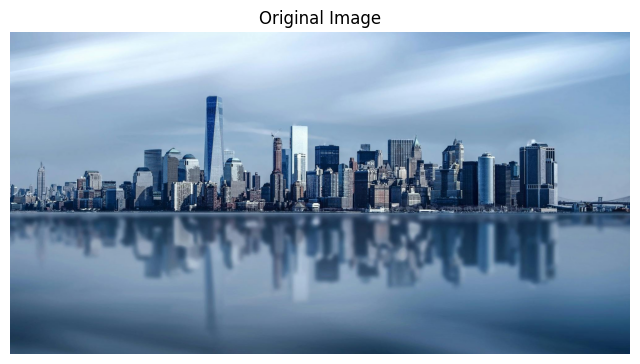

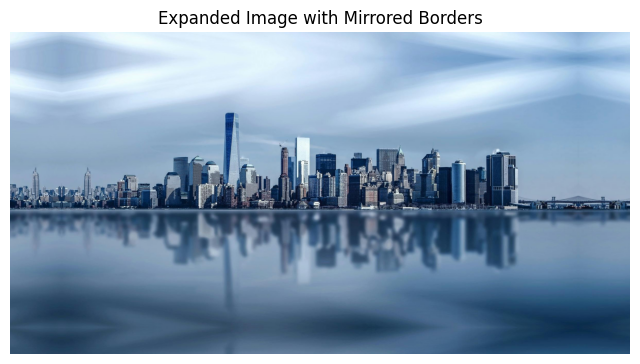

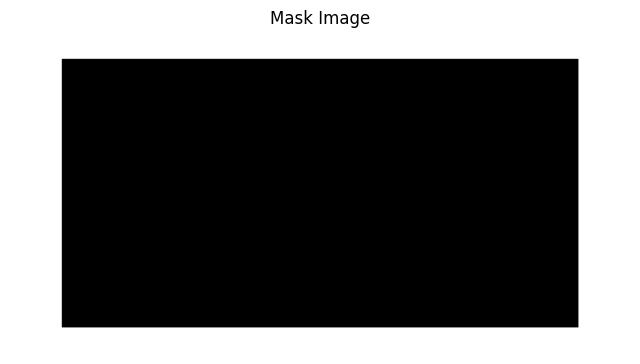

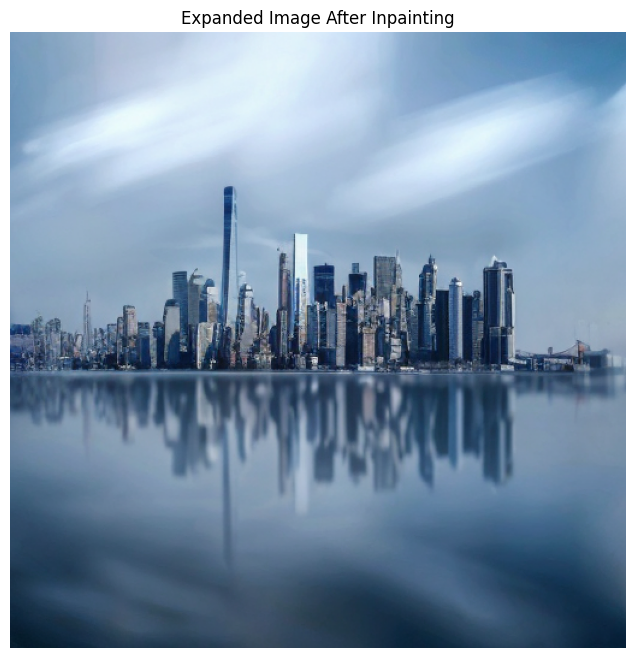

In [47]:
import matplotlib.pyplot as plt

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Display the expanded image with mirrored borders
plt.figure(figsize=(8, 8))
plt.imshow(expanded_image)
plt.title("Expanded Image with Mirrored Borders")
plt.axis("off")
plt.show()

# Display the mask
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap="gray")
plt.title("Mask Image")
plt.axis("off")
plt.show()

# Display the inpainted (expanded) image
plt.figure(figsize=(8, 8))
plt.imshow(inpainted_image)
plt.title("Expanded Image After Inpainting")
plt.axis("off")
plt.show()
